In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40
DATA_PATH = "./MURA-v1.1"
TRAIN_PATH = DATA_PATH + "/train_labeled_studies.csv"
VALID_PATH = DATA_PATH + "/valid_labeled_studies.csv"

# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels = [], []
    base_dir = "./"  # Root dataset directory
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        for image_file in os.listdir(study_path):
            image_path = os.path.join(study_path, image_file)
            if image_path.endswith(".png") and not image_file.startswith("._"):
                image_paths.append(image_path)
                labels.append(label)
    return np.array(image_paths), np.array(labels)

train_image_paths, train_labels = load_data(TRAIN_PATH)
valid_image_paths, valid_labels = load_data(VALID_PATH)
X_train, X_test, y_train, y_test = train_test_split(train_image_paths, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Custom Data Generator Class
class MURADataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)
    
    def __data_generation(self, batch_paths, batch_labels):
        images = []
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize
            img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
            if self.augment:
                img = self.datagen.random_transform(img)
            images.append(img)
        return np.array(images).reshape(-1, *self.img_size, 3), np.array(batch_labels)

# Load Pretrained Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Gradually Unfreeze Layers
for layer in base_model.layers[:-50]:  # Keep first layers frozen
    layer.trainable = False
for layer in base_model.layers[-50:]:  # Unfreeze last 40 layers
    layer.trainable = True

# Add Custom Classifier Head
x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary Classification

# Compile Model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model3.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Generators
train_generator = MURADataGenerator(X_train, y_train, augment=True)
valid_generator = MURADataGenerator(valid_image_paths, valid_labels, augment=False, shuffle=False)

test_generator = MURADataGenerator(X_test, y_test, augment=False, shuffle=False)

# Train Model
model.fit(train_generator, validation_data=valid_generator, epochs=EPOCHS, callbacks=[lr_scheduler, early_stopping ,model_checkpoint])

# Evaluate Model
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
predictions = model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)

# Display some results
for i in range(60):
    print(f"Actual: {y_test[i]}, Predicted: {predictions[i][0]}")


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1135']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1740497900.930569   45096 service.cc:148] XLA service 0x744ba0004070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740497900.930587   45096 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-02-25 17:38:21.523185: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740497904.441854   45096 cuda_dnn.cc:529] Loaded cuDNN version 90701


   1/1036 ━━━━━━━━━━━━━━━━━━━━ 11:46:13 41s/step - accuracy: 0.5625 - loss: 16.2112

I0000 00:00:1740497924.652444   45096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6024 - loss: 10.0474
Epoch 1: val_accuracy improved from -inf to 0.74226, saving model to best_model3.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 452s 397ms/step - accuracy: 0.6024 - loss: 10.0450 - val_accuracy: 0.7423 - val_loss: 3.9715 - learning_rate: 1.0000e-04
Epoch 2/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7093 - loss: 3.2700
Epoch 2: val_accuracy improved from 0.74226 to 0.74570, saving model to best_model3.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 376s 363ms/step - accuracy: 0.7093 - loss: 3.2694 - val_accuracy: 0.7457 - val_loss: 1.7712 - learning_rate: 1.0000e-04
Epoch 3/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7468 - loss: 1.5550
Epoch 3: val_accuracy improved from 0.74570 to 0.77010, saving model to best_model3.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 374s 361ms/step - accuracy: 0.7468 - loss: 1.5549 - val_accuracy: 0.7701 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 4/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7641 - loss: 0.9996
Epoch 4: val_accuracy did not improve from 0.77010
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 369s 356ms/step - accuracy: 0.7641 - loss: 0.9995 - val_accuracy: 0.7642 - val_loss: 0.8111 - learning_rate: 1.0000e-04
Epoch 5/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7724 - loss: 0.7576
Epoch 5: val_accuracy did not improve from 0.77010
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 360s 348ms/step - accuracy: 0.7724 - loss: 0.7576 - val_accuracy: 0.7673 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 6/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7791 - loss: 0.6575
Epoch 6: val_accuracy did not improve from 0.77010
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 371s 358ms/step - accuracy: 0.7791 - loss: 0.6574 - val_accuracy: 0.7670 - val_loss: 0.6420 -

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 372s 359ms/step - accuracy: 0.7883 - loss: 0.6108 - val_accuracy: 0.7848 - val_loss: 0.6070 - learning_rate: 1.0000e-04
Epoch 8/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7918 - loss: 0.5966
Epoch 8: val_accuracy did not improve from 0.78480
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 369s 356ms/step - accuracy: 0.7918 - loss: 0.5966 - val_accuracy: 0.7695 - val_loss: 0.6189 - learning_rate: 1.0000e-04
Epoch 9/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7935 - loss: 0.5903
Epoch 9: val_accuracy improved from 0.78480 to 0.78574, saving model to best_model3.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 372s 359ms/step - accuracy: 0.7935 - loss: 0.5903 - val_accuracy: 0.7857 - val_loss: 0.6053 - learning_rate: 1.0000e-04
Epoch 10/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7986 - loss: 0.5832
Epoch 10: val_accuracy did not improve from 0.78574
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 366s 353ms/step - accuracy: 0.7986 - loss: 0.5832 - val_accuracy: 0.7845 - val_loss: 0.6181 - learning_rate: 1.0000e-04
Epoch 11/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8026 - loss: 0.5732
Epoch 11: val_accuracy did not improve from 0.78574
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 368s 355ms/step - accuracy: 0.8026 - loss: 0.5732 - val_accuracy: 0.7776 - val_loss: 0.6424 - learning_rate: 1.0000e-04
Epoch 12/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8055 - loss: 0.5681
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 12: val_accuracy did not improve from 0.78574
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 369s 356m

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 372s 359ms/step - accuracy: 0.8134 - loss: 0.5262 - val_accuracy: 0.7867 - val_loss: 0.5709 - learning_rate: 5.0000e-05
Epoch 14/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8151 - loss: 0.5058
Epoch 14: val_accuracy improved from 0.78668 to 0.79199, saving model to best_model3.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 374s 361ms/step - accuracy: 0.8151 - loss: 0.5058 - val_accuracy: 0.7920 - val_loss: 0.5518 - learning_rate: 5.0000e-05
Epoch 15/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8228 - loss: 0.4914
Epoch 15: val_accuracy did not improve from 0.79199
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 367s 354ms/step - accuracy: 0.8228 - loss: 0.4914 - val_accuracy: 0.7767 - val_loss: 0.5990 - learning_rate: 5.0000e-05
Epoch 16/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8243 - loss: 0.4906
Epoch 16: val_accuracy improved from 0.79199 to 0.79887, saving model to best_model3.h5


1036/1036 ━━━━━━━━━━━━━━━━━━━━ 374s 361ms/step - accuracy: 0.8243 - loss: 0.4906 - val_accuracy: 0.7989 - val_loss: 0.5531 - learning_rate: 5.0000e-05
Epoch 17/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8277 - loss: 0.4770
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 17: val_accuracy did not improve from 0.79887
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 367s 354ms/step - accuracy: 0.8277 - loss: 0.4770 - val_accuracy: 0.7895 - val_loss: 0.5688 - learning_rate: 5.0000e-05
Epoch 18/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8335 - loss: 0.4586
Epoch 18: val_accuracy did not improve from 0.79887
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 368s 355ms/step - accuracy: 0.8335 - loss: 0.4586 - val_accuracy: 0.7932 - val_loss: 0.5386 - learning_rate: 2.5000e-05
Epoch 19/40
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8311 - loss: 0.4496
Epoch 19: val_accuracy did not improve from 0.79887
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 371s 358m

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1135']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step
Actual: 1, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted

In [4]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("best_model3.h5")


In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


116/116 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.7972 - loss: 0.5346
Test Accuracy: 80.09%


In [6]:
test_loss, train_accuracy = model.evaluate(train_generator)
print(f"train Accuracy: {train_accuracy * 100:.2f}%")

1036/1036 ━━━━━━━━━━━━━━━━━━━━ 390s 376ms/step - accuracy: 0.8351 - loss: 0.4603
train Accuracy: 83.49%


In [7]:
print(f"Fixed y_test shape: {y_test.shape}")
print(f"Fixed predictions shape: {predictions.shape}")



Fixed y_test shape: (3681,)
Fixed predictions shape: (3681, 1)


In [8]:
# Predictions
predictions = model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)

116/116 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step


In [9]:
import numpy as np
# Ensure predictions are flattened
predictions = predictions.flatten()
# Convert to NumPy arrays
y_test = np.array(y_test).astype(int)
predictions = np.array(predictions).astype(int)

# Count correct and incorrect predictions
true_positives = np.sum((predictions == 1) & (y_test == 1))
true_negatives = np.sum((predictions == 0) & (y_test == 0))
false_positives = np.sum((predictions == 1) & (y_test == 0))
false_negatives = np.sum((predictions == 0) & (y_test == 1))

# Print results
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# Calculate accuracy
accuracy = (true_positives + true_negatives) / len(y_test)
print(f"Calculated Accuracy: {accuracy * 100:.2f}%")


True Positives: 975
True Negatives: 1973
False Positives: 221
False Negatives: 512
Calculated Accuracy: 80.09%


In [10]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.82
Recall: 0.66


In [11]:
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.2f}")

F1-Score: 0.73


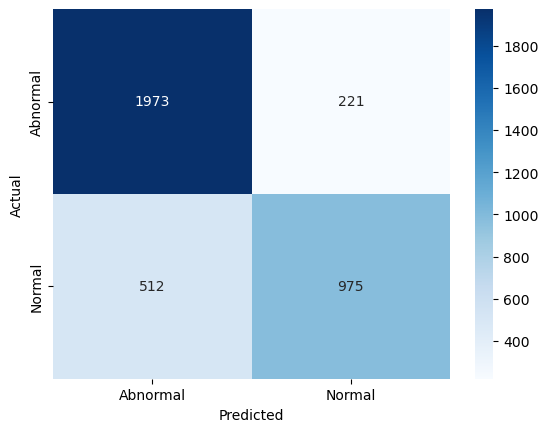

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Abnormal", "Normal"], yticklabels=["Abnormal", "Normal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's Kappa: {kappa:.2f}")


Cohen's Kappa: 0.57
